In [36]:
import networkx as nx
import torch
import torch.nn.functional as F
import torch_geometric
import random 
import numpy as np
from tqdm import tqdm
import copy
import itertools

## Data preparation

We generate graphs as instructed, resulting in 4 splits for training and cross-validation, and one split for testing.

In [37]:
def gen_graph_pairs(min_n, max_n):
  pairs = []
  for n in range(min_n, max_n+1):
    for k in range(3, n-2):
      single = nx.cycle_graph(n)
      disjoint = nx.disjoint_union(nx.cycle_graph(k),
                                   nx.cycle_graph(n-k))
      pairs.append((single, disjoint))
  return pairs

In [38]:
def to_pyg(g, label):
  data = torch_geometric.utils.from_networkx(g)
  data.x = torch.zeros((g.number_of_nodes(), 50))
  data.y = torch.tensor([label])
  return data


def split(data_pairs):
  random.shuffle(data_pairs)
  split_size = len(data_pairs)//5
  splits = [data_pairs[i:i+split_size] for i in 
            range(0, len(data_pairs), split_size)]
  for i in range(len(splits)):    
    splits[i] = list(sum(splits[i], ())) # flatten list of tuples
    random.shuffle(splits[i]) # shuffle positive/negative examples in split
  return splits



## Quantum

### Initial experiment

In [39]:
graph_pairs = gen_graph_pairs(6, 6)
data_pairs = [(to_pyg(g1, 1), to_pyg(g2, 0)) for (g1,g2) in graph_pairs]
data_pairs # two 3-cycles vs one 6-cycle

[(Data(edge_index=[2, 12], num_nodes=6, x=[6, 50], y=[1]),
  Data(edge_index=[2, 12], num_nodes=6, x=[6, 50], y=[1]))]

In [40]:
two_triangles = data_pairs[0][1]
one_6cycle = data_pairs[0][0]

In [41]:
class QGNN(torch.nn.Module):
    def __init__(self, n_qubits=1, n_nodes=6, verbose = False):
        super(QGNN, self).__init__()
        self.verbose = verbose
        self.n_qubits = n_qubits
        self.n_nodes = n_nodes
        self.rots = torch.rand(n_qubits, n_qubits)*2*np.pi
        self.total_qubits = n_qubits*n_nodes
        self.state_dim = 2**self.total_qubits
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(self.state_dim, self.state_dim//2),
            torch.nn.ReLU(),
            torch.nn.Linear(self.state_dim//2, 1)
        )

    # Note: this implementation was chosen not for efficiency, but in the
    # hope that thinking in such low-level operations might help give
    # intuitions about the expressivity and inductive bias of the model.
    def forward(self, graph):
        edges = graph.edge_index

        # start as |++...+>, uniform superposition over all bitstrings
        state = torch.ones(self.state_dim, dtype=torch.cfloat) / (2**(self.total_qubits/2))

        if self.verbose:
          print("Sanity check: init prob mass", torch.sum(torch.square(torch.abs(state))).numpy())

        
        for edge in range(edges.shape[1]):
          # for each edge, apply matrix of CZ rotations
          for l in range(self.n_qubits):            
            for r in range(self.n_qubits):
              # apply CZ(rots[l][r]) between appropriate qubits
              ql = (edges[0][edge]*self.n_qubits + l).numpy()
              qr = (edges[1][edge]*self.n_qubits + r).numpy()
              for s in range(self.state_dim):
                # search for state entries where ql, qr are 1 and apply phase 
                if (s & (1 << ql)) and (s & (1 << qr)):
                  #if torch.abs(state[s]) > 0.001:
                  #  print('Applying phase to state ' + str(s) + ' from edge between qubits ' + str(ql)  + ', ' + str(qr))
                  state[s] *= torch.exp(self.rots[l][r]*1j)
        if self.verbose:
          print(state.numpy())
        # Apply Hadamard on each qubit.
        # Each bitstring goes to each bitstring with +-1/2^(n/2) of its
        # probability amplitude, with the sign determined by the number of
        # 1s at the same position in source and target
        out = torch.zeros(self.state_dim, dtype=torch.cfloat) 
        norm = 1/(2**(self.total_qubits/2))
        for s in range(self.state_dim):
          for t in range(self.state_dim):
            weight = state[s]*norm
            for i in range(self.total_qubits):
              if (s & (1 << i)) and (t & (1 << i)):
                weight *= -1
            out[t] += weight

        if self.verbose:
          print("Sanity check: final prob mass", torch.sum(torch.square(torch.abs(out))).numpy())        
        
        probs = torch.square(torch.abs(out))
        if self.verbose:
          print(probs.numpy())
        odds = 0
        evens = 0
        big = 0
        small = 0
        counts = np.zeros(self.total_qubits+1)
        for s in range(len(probs)):
          ones = 0
          for i in range(self.total_qubits):
            if (s & (1 << i)):
              ones += 1
          counts[ones] += probs[s]
          if ones >= self.total_qubits//2:
            big += probs[s]          
          else:
            small += probs[s]
          if ones % 2 == 0:
            evens += probs[s]
          else:
            odds += probs[s]
        if self.verbose:
          print("evens vs odds: " + str(evens) + ", " + str(odds))
          print("big vs small: " + str(big) + ", " + str(small))
          print("1-count distr: ")
          print(counts)
        return counts

In [42]:
# import pennylane as qml

# class QGNN(torch.nn.Module):
#     def __init__(self, n_qubits=1, n_nodes=6, verbose=False):
#         super(QGNN, self).__init__()
#         self.verbose = verbose
#         self.n_qubits = n_qubits
#         self.n_nodes = n_nodes
#         self.total_qubits = n_qubits * n_nodes
#         self.state_dim = 2 ** self.total_qubits

#         # Match original parameterization
#         self.rots = torch.rand(n_qubits, n_qubits) * 2 * np.pi

#         # PennyLane device with statevector access
#         self.dev = qml.device("default.qubit", wires=self.total_qubits, shots=None)

#         # Define the quantum circuit as a QNode that outputs the full statevector
#         @qml.qnode(self.dev, interface="torch", diff_method=None)
#         def circuit(theta, edges_tensor):
#             # Prepare |+...+> = H on all qubits starting from |0...0>
#             for w in range(self.total_qubits):
#                 qml.Hadamard(wires=w)

#             # Apply per-edge Controlled-Phase(theta) between appropriate node-qubit wires
#             # Equivalent to CZ(theta): diag(1,1,1, e^{i theta})
#             # Implement as controlled RZ with phase distributed via global frame:
#             # PennyLane's ControlledPhaseShift applies diag(1,1,1,e^{i theta}) directly.
#             edges = edges_tensor
#             for e in range(edges.shape[1]):
#                 u = int(edges[0, e].item())
#                 v = int(edges[1, e].item())
#                 # For n_qubits=1, only (l=0, r=0) is used; keep loops for compatibility
#                 for l in range(self.n_qubits):
#                     for r in range(self.n_qubits):
#                         ql = u * self.n_qubits + l
#                         qr = v * self.n_qubits + r
#                         qml.ControlledPhaseShift(theta, wires=[ql, qr])

#             # Final layer: Hadamard on each qubit (as in original)
#             for w in range(self.total_qubits):
#                 qml.Hadamard(wires=w)

#             # Return full statevector
#             return qml.state()

#         self._circuit = circuit

#         # Keep the MLP definition to avoid breaking references, though it is unused in forward’s return
#         self.mlp = torch.nn.Sequential(
#             torch.nn.Linear(self.state_dim, self.state_dim // 2),
#             torch.nn.ReLU(),
#             torch.nn.Linear(self.state_dim // 2, 1)
#         )

#     def forward(self, graph):
#         edges = graph.edge_index  # shape [2, E], torch.long
#         # Ensure CPU tensors for PennyLane
#         if edges.is_cuda:
#             edges = edges.cpu()

#         theta = self.rots[0, 0]  # only single-parameter case used in the notebook
#         # Run circuit and get statevector as a complex torch tensor
#         state = self._circuit(theta, edges)

#         # Convert to probabilities
#         probs = torch.abs(state) ** 2  # shape [2**total_qubits]

#         if self.verbose:
#             print("Sanity check: final prob mass", torch.sum(probs).detach().cpu().numpy())

#         # Compute Hamming-weight histogram counts[k] = sum_{|s|=k} probs[s]
#         counts = np.zeros(self.total_qubits + 1, dtype=np.float64)
#         # Iterate over computational basis indices
#         # Using NumPy loop for simplicity; keep identical result to original
#         probs_np = probs.detach().cpu().numpy()
#         for s in range(probs_np.shape[0]):
#             ones = int(bin(s).count("1"))
#             counts[ones] += probs_np[s]

#         return counts

import numpy as np
import torch
import pennylane as qml

class QGNN(torch.nn.Module):
    def __init__(self, n_qubits=1, n_nodes=6, verbose=False):
        super(QGNN, self).__init__()
        self.verbose = verbose
        self.n_qubits = n_qubits
        self.n_nodes = n_nodes
        self.total_qubits = n_qubits * n_nodes
        self.state_dim = 2 ** self.total_qubits
        
        # Same random initialization as PyTorch version
        self.rots = torch.rand(n_qubits, n_qubits) * 2 * np.pi
        
        # PennyLane device (statevector simulator)
        self.dev = qml.device("default.qubit", wires=self.total_qubits, shots=None)
        
        @qml.qnode(self.dev, interface="torch", diff_method=None)
        def circuit(rots, edges_tensor):
            # Start as |+...+> (uniform superposition)
            for w in range(self.total_qubits):
                qml.Hadamard(wires=w)
            
            # Apply CZ(rots[l][r]) for each edge and (l, r) pair
            edges = edges_tensor
            for e in range(edges.shape[1]):
                u = int(edges[0, e].item())
                v = int(edges[1, e].item())
                for l in range(self.n_qubits):
                    for r in range(self.n_qubits):
                        angle = rots[l, r]
                        ql = u * self.n_qubits + l
                        qr = v * self.n_qubits + r
                        qml.ControlledPhaseShift(angle, wires=[ql, qr])
            
            # Final Hadamard layer
            for w in range(self.total_qubits):
                qml.Hadamard(wires=w)
            
            return qml.state()
        
        self._circuit = circuit

    def forward(self, graph):
        edges = graph.edge_index
        if edges.is_cuda:
            edges = edges.cpu()
        edges = edges.to(dtype=torch.long)
        
        # Run quantum circuit
        state = self._circuit(self.rots, edges)
        
        # Convert to probabilities
        probs = torch.abs(state) ** 2
        
        if self.verbose:
            print("Sanity check: final prob mass", torch.sum(probs).item())
        
        # Build Hamming weight histogram
        counts = np.zeros(self.total_qubits + 1, dtype=np.float64)
        probs_np = probs.detach().cpu().numpy()
        odds = evens = big = small = 0.0
        
        for s in range(len(probs_np)):
            ones = bin(s).count("1")
            counts[ones] += probs_np[s]
            
            if ones % 2 == 0:
                evens += probs_np[s]
            else:
                odds += probs_np[s]
            if ones >= self.total_qubits // 2:
                big += probs_np[s]
            else:
                small += probs_np[s]
        
        if self.verbose:
            print("evens vs odds:", evens, odds)
            print("big vs small:", big, small)
            print("1-count distr:", counts)
        
        return counts


In [43]:
# import torch
# import numpy as np
# import pennylane as qml

# # -------------------------------
# # Your original manual PyTorch QGNN
# # -------------------------------
# class QGNN_PyTorch(torch.nn.Module):
#     def __init__(self, n_qubits=1, n_nodes=6, verbose=False):
#         super(QGNN_PyTorch, self).__init__()
#         self.verbose = verbose
#         self.n_qubits = n_qubits
#         self.n_nodes = n_nodes
#         self.rots = torch.rand(n_qubits, n_qubits) * 2 * np.pi
#         self.total_qubits = n_qubits * n_nodes
#         self.state_dim = 2 ** self.total_qubits

#     def forward(self, graph):
#         edges = graph.edge_index
#         state = torch.ones(self.state_dim, dtype=torch.cfloat) / (2 ** (self.total_qubits / 2))

#         # Controlled-phase application
#         for edge in range(edges.shape[1]):
#             for l in range(self.n_qubits):
#                 for r in range(self.n_qubits):
#                     ql = int(edges[0][edge].item() * self.n_qubits + l)
#                     qr = int(edges[1][edge].item() * self.n_qubits + r)
#                     for s in range(self.state_dim):
#                         if (s & (1 << ql)) and (s & (1 << qr)):
#                             state[s] *= torch.exp(1j * self.rots[l][r])

#         # Final Hadamard layer
#         out = torch.zeros(self.state_dim, dtype=torch.cfloat)
#         norm = 1 / (2 ** (self.total_qubits / 2))
#         for s in range(self.state_dim):
#             for t in range(self.state_dim):
#                 weight = state[s] * norm
#                 for i in range(self.total_qubits):
#                     if (s & (1 << i)) and (t & (1 << i)):
#                         weight *= -1
#                 out[t] += weight

#         probs = torch.square(torch.abs(out))

#         counts = np.zeros(self.total_qubits + 1)
#         for s in range(len(probs)):
#             ones = bin(s).count("1")
#             counts[ones] += probs[s].item()
#         return counts


# # -------------------------------
# # Equivalent PennyLane QGNN
# # -------------------------------
# class QGNN_PennyLane(torch.nn.Module):
#     def __init__(self, n_qubits=1, n_nodes=6, verbose=False):
#         super(QGNN_PennyLane, self).__init__()
#         self.verbose = verbose
#         self.n_qubits = n_qubits
#         self.n_nodes = n_nodes
#         self.total_qubits = n_qubits * n_nodes
#         self.state_dim = 2 ** self.total_qubits
#         self.rots = torch.rand(n_qubits, n_qubits) * 2 * np.pi
#         self.dev = qml.device("default.qubit", wires=self.total_qubits, shots=None)

#         @qml.qnode(self.dev, interface="torch", diff_method=None)
#         def circuit(rots, edges_tensor):
#             for w in range(self.total_qubits):
#                 qml.Hadamard(wires=w)
#             for e in range(edges_tensor.shape[1]):
#                 u = int(edges_tensor[0, e].item())
#                 v = int(edges_tensor[1, e].item())
#                 for l in range(self.n_qubits):
#                     for r in range(self.n_qubits):
#                         angle = rots[l, r]
#                         ql = u * self.n_qubits + l
#                         qr = v * self.n_qubits + r
#                         qml.ControlledPhaseShift(angle, wires=[ql, qr])
#             for w in range(self.total_qubits):
#                 qml.Hadamard(wires=w)
#             return qml.state()

#         self._circuit = circuit

#     def forward(self, graph):
#         edges = graph.edge_index
#         if edges.is_cuda:
#             edges = edges.cpu()
#         edges = edges.to(dtype=torch.long)
#         state = self._circuit(self.rots, edges)
#         probs = torch.abs(state) ** 2
#         counts = np.zeros(self.total_qubits + 1)
#         probs_np = probs.detach().cpu().numpy()
#         for s in range(len(probs_np)):
#             ones = bin(s).count("1")
#             counts[ones] += probs_np[s]
#         return counts


# # -------------------------------
# # Test for equivalence
# # -------------------------------
# # Dummy graph with 6 nodes, edges as an example
# class DummyGraph:
#     def __init__(self, edge_index):
#         self.edge_index = edge_index

# # Example edge list: fully connected 6-node ring
# edges = torch.tensor([[0, 1, 2, 3, 4, 5],
#                       [1, 2, 3, 4, 5, 0]], dtype=torch.long)

# graph = DummyGraph(edges)

# # Create models
# torch_model = QGNN_PyTorch(n_qubits=1, n_nodes=6)
# pl_model = QGNN_PennyLane(n_qubits=1, n_nodes=6)

# # Force same parameters
# pl_model.rots = torch_model.rots.clone()

# # Forward pass
# counts_torch = torch_model(graph)
# counts_pl = pl_model(graph)

# # Compare
# print("PyTorch counts:", counts_torch)
# print("PennyLane counts:", counts_pl)
# print("Difference:", counts_torch - counts_pl)
# print("Are they close?", np.allclose(counts_torch, counts_pl))


### Permute edge lists to confirm invariance

In [44]:
perm = np.random.permutation(two_triangles.edge_index.shape[1])
two_triangles_alt = copy.deepcopy(two_triangles)
two_triangles_alt.edge_index = two_triangles_alt.edge_index[:, perm]
one_6cycle_alt = copy.deepcopy(one_6cycle)
one_6cycle_alt.edge_index = one_6cycle_alt.edge_index[:, perm]
print(two_triangles.edge_index)
print(two_triangles_alt.edge_index)

qgnn = QGNN()

tensor([[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5],
        [1, 2, 0, 2, 0, 1, 4, 5, 3, 5, 3, 4]])
tensor([[5, 1, 1, 3, 4, 2, 0, 0, 3, 4, 2, 5],
        [4, 2, 0, 4, 5, 1, 1, 2, 5, 3, 0, 3]])


In [45]:
print(qgnn(two_triangles))
print(qgnn(two_triangles_alt))

[0.09931937 0.07007652 0.11807843 0.29316217 0.11839758 0.13617482
 0.16479111]
[0.09931937 0.07007652 0.11807843 0.29316217 0.11839758 0.13617482
 0.16479111]


In [46]:
print(qgnn(one_6cycle))
print(qgnn(one_6cycle_alt))

[0.03442182 0.07007652 0.16559492 0.29316217 0.21805727 0.13617482
 0.08251248]
[0.03442182 0.07007652 0.16559492 0.29316217 0.21805727 0.13617482
 0.08251248]


### Animate 1-count distribution as a function of the single parameter

In [47]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')


In [48]:
def create_anim(inps, frames, titles=None):
  fig, axs = plt.subplots(len(inps))
  for i, ax in enumerate(axs):
    ax.set_ylim(bottom=0, top=1)
    if titles:
      ax.set_title(titles[i])
  bins = inps[0].x.shape[0] + 1
  bar_containers = [ax.bar(np.linspace(0, 6, 7), np.zeros(bins)) for ax in axs]
  rotations = np.linspace(-np.pi/2, +np.pi/2, frames)

  def write_frame(frame_number):
      # simulate new data coming in
      qgnn = QGNN(n_qubits=1)
      qgnn.rots[0][0] = rotations[frame_number]
      for input, bar_container in zip(inps, bar_containers):
        probs = qgnn(input)      
        for prob, rect in zip(probs, bar_container.patches):
            rect.set_height(prob)
      return itertools.chain.from_iterable(bar_container.patches for bar_container in bar_containers)

  ax.set_ylim(top=1)  # set safe limit to ensure that all data is visible.

  ani = animation.FuncAnimation(fig, lambda frame: write_frame(frame), frames,
                                repeat=False, blit=True)
  return ani

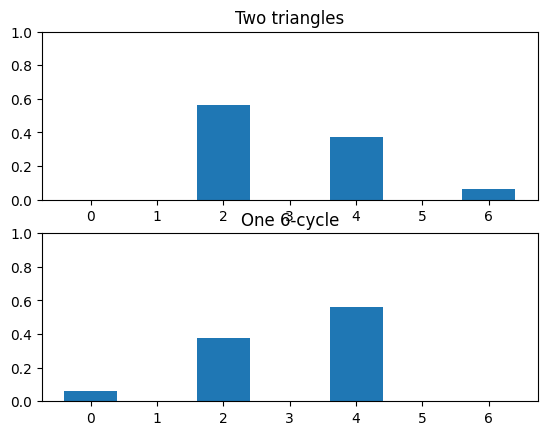

In [49]:
create_anim([two_triangles, one_6cycle], 60, titles=["Two triangles", "One 6-cycle"])

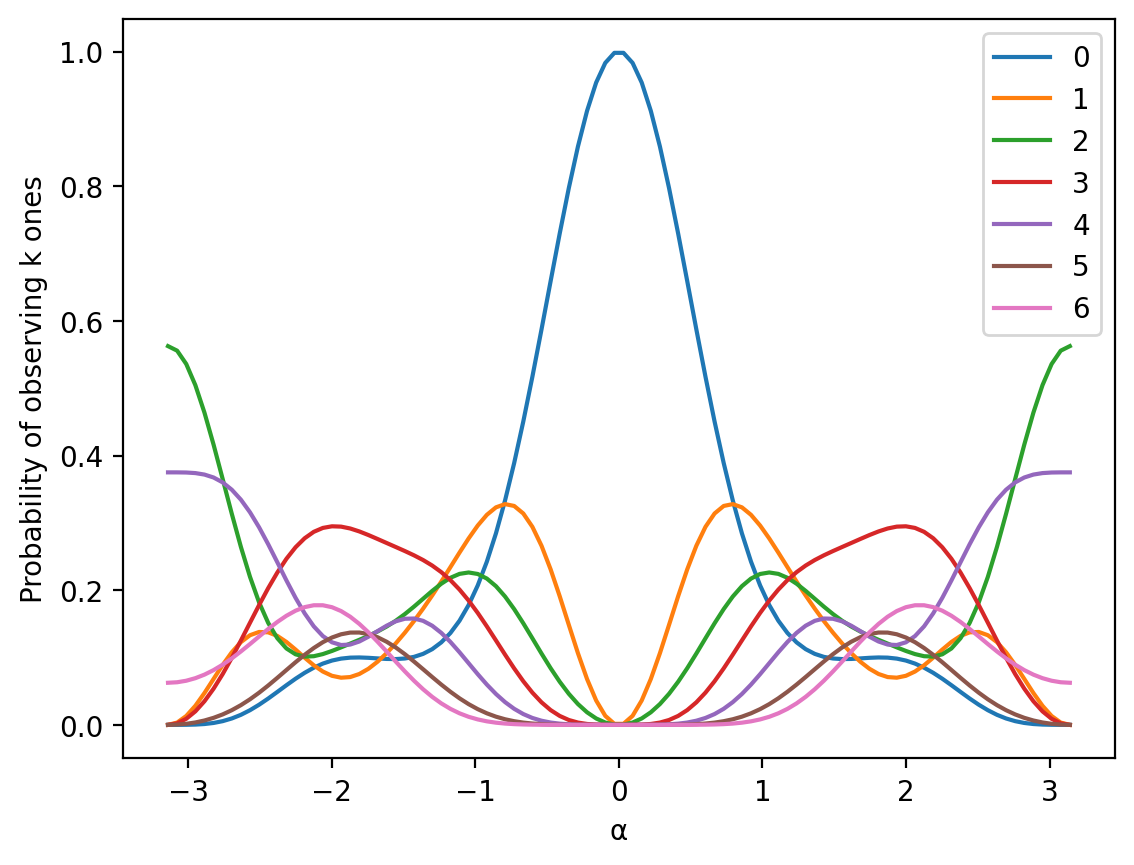

In [50]:
def plot_wrt_alpha(graph):
  x = np.linspace(-np.pi, np.pi, 100)
  ys = np.zeros((7,0))
  for alpha in x:
    qgnn = QGNN(n_qubits=1)
    qgnn.rots[0][0] = alpha/2
    probs = np.expand_dims(qgnn(graph), 1)
    ys = np.concatenate((ys, probs), axis=1)
  plt.figure(dpi=200)
  for y in ys:
    plt.plot(x, y)
  plt.xlabel('α')
  plt.ylabel('Probability of observing k ones')
  plt.legend(labels=range(0,7), loc='upper right')
  plt.show()

plot_wrt_alpha(two_triangles)

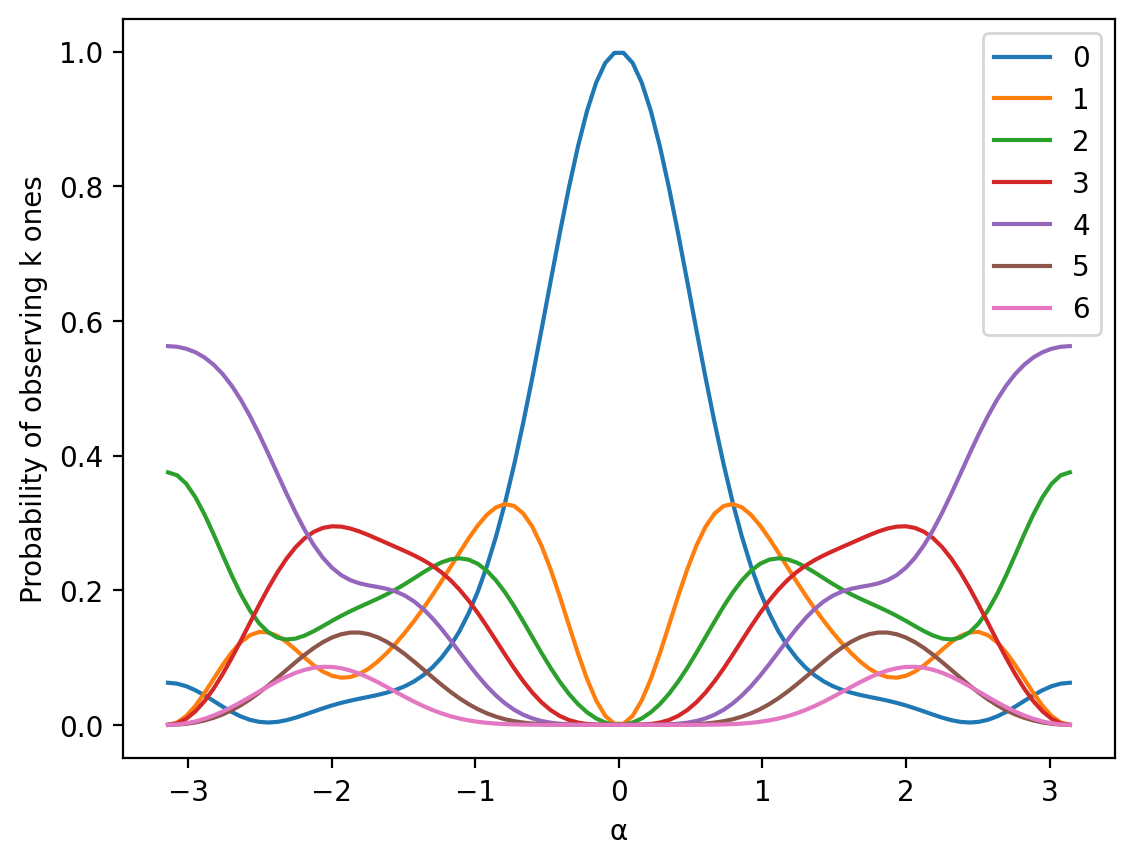

In [51]:
plot_wrt_alpha(one_6cycle)

### Same experiment with larger size graphs

In [52]:
def gen_one_cycle(n):
  return to_pyg(nx.cycle_graph(n), 1)


def gen_two_cycles(n):
  return to_pyg(nx.disjoint_union(nx.cycle_graph(n//2), nx.cycle_graph(n//2+n%2)), 1)

def plot_czpi_hist(n):
  qgnn = QGNN(n_qubits=1, n_nodes=n)
  qgnn.rots[0][0] = np.pi/2
  g1 = gen_one_cycle(n)
  g2 = gen_two_cycles(n)
  fig, axs = plt.subplots(2)
  for ax in axs:
    ax.set_ylim(bottom=0, top=1)
  axs[0].bar(range(n+1), qgnn(g1))
  axs[1].bar(range(n+1), qgnn(g2))
  plt.show()

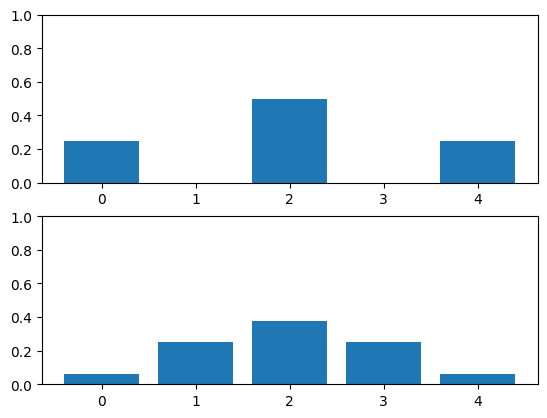

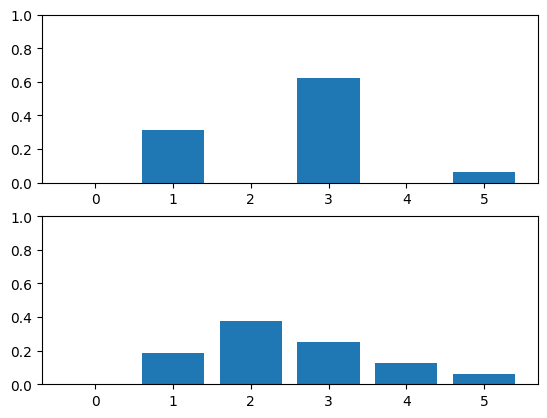

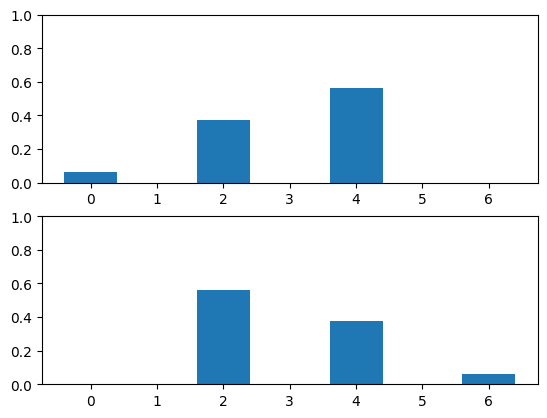

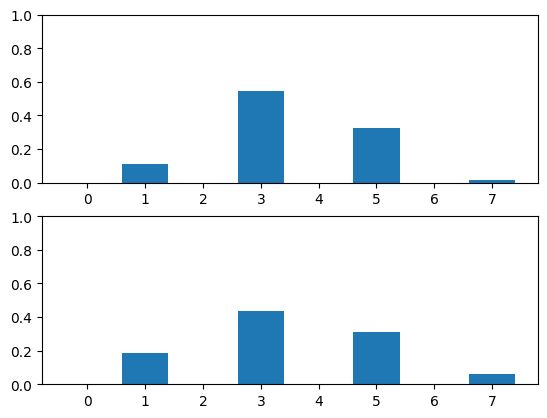

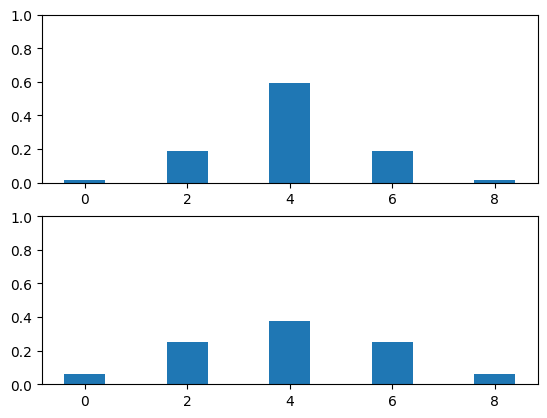

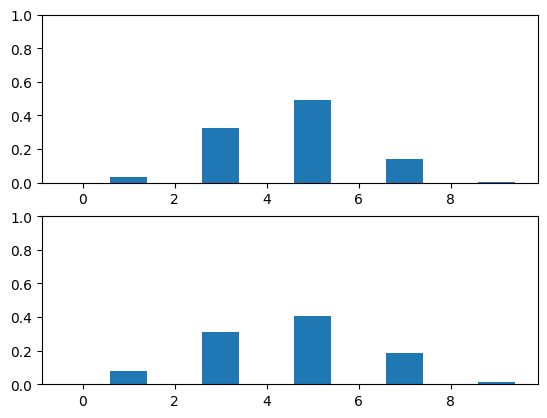

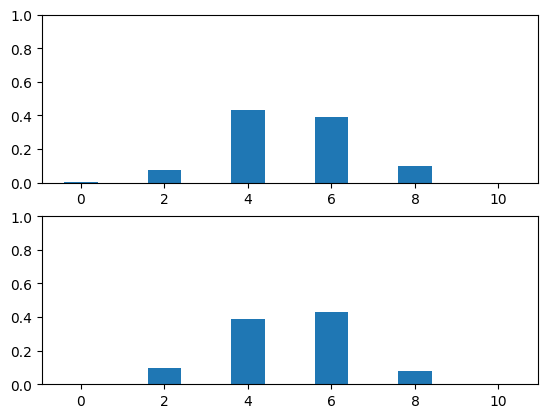

In [53]:
for i in range(4, 11):
  plot_czpi_hist(i)